In [1]:
import os, gc, torch, PIL, pickle,json,io

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import DEFAULT_REFLACX_LABEL_COLS

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

from enum import Enum

class FROCEarlyStopModels(Enum):
    baseline_mobilenet = "val_lesion-detection_froc_0_8214_test_lesion-detection_froc_0_7215_epoch29_05-08-2023 03-29-15_lesion_dsetection_baseline_mobilenet"
    with_clinical_mobilenet_1D_3D = "val_lesion-detection_froc_0_7802_test_lesion-detection_froc_0_7193_epoch27_05-08-2023 04-57-59_lesion_dsetection_with_clinical_mobilenet"
    with_clinical_mobilenet_3D = "val_lesion-detection_froc_0_8345_test_lesion-detection_froc_0_7381_epoch31_05-08-2023 08-28-01_lesion_dsetection_with_clinical_mobilenet"
    baseline_resnet18 = "val_lesion-detection_froc_0_8262_test_lesion-detection_froc_0_7828_epoch21_05-08-2023 10-52-48_lesion_dsetection_baseline_resnet18"
    with_clinical_resnet18_1D_3D = "val_lesion-detection_froc_0_8063_test_lesion-detection_froc_0_7156_epoch21_05-08-2023 17-24-35_lesion_dsetection_with_clinical_resnet18"
    with_clinical_resnet18_3D = "val_lesion-detection_froc_0_8391_test_lesion-detection_froc_0_7007_epoch51_05-09-2023 00-03-18_lesion_dsetection_with_clinical_resnet18"
    baseline_convnext_base = "val_lesion-detection_froc_0_8422_test_lesion-detection_froc_0_7991_epoch39_05-09-2023 03-20-36_lesion_dsetection_baseline_convnext_base"
    with_clinical_convnext_base_1D_3D = "val_lesion-detection_froc_0_8248_test_lesion-detection_froc_0_7867_epoch45_05-09-2023 07-31-28_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    with_clinical_convnext_base_3D = "val_lesion-detection_froc_0_8104_test_lesion-detection_froc_0_7584_epoch62_05-09-2023 12-56-34_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_3D_2nd = "val_lesion-detection_froc_0_8148_test_lesion-detection_froc_0_7649_epoch39_05-09-2023 17-27-41_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_1D_3D_2nd = "val_lesion-detection_froc_0_8409_test_lesion-detection_froc_0_8003_epoch29_05-09-2023 19-09-54_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    baseline_convnext_base_2nd = "val_lesion-detection_froc_0_8597_test_lesion-detection_froc_0_8035_epoch41_05-09-2023 21-40-22_lesion_dsetection_baseline_convnext_base"
    baseline_efficientnet_b0 = "val_lesion-detection_froc_0_8301_test_lesion-detection_froc_0_7479_epoch23_05-09-2023 23-23-11_lesion_dsetection_baseline_efficientnet_b0"
    with_clinical_efficientnet_b0_1D_3D = "val_lesion-detection_froc_0_7876_test_lesion-detection_froc_0_7051_epoch35_05-10-2023 07-17-37_lesion_dsetection_with_clinical_efficientnet_b0_1D_3D"
    with_clinical_efficientnet_b0_3D = "val_lesion-detection_froc_0_8321_test_lesion-detection_froc_0_7246_epoch25_05-10-2023 09-19-11_lesion_dsetection_with_clinical_efficientnet_b0_3D"
    baseline_densenet = "val_lesion-detection_froc_0_8442_test_lesion-detection_froc_0_6942_epoch33_05-10-2023 17-06-03_lesion_dsetection_baseline_densenet"
    with_clinical_densenet_1D_3D = "val_lesion-detection_froc_0_8303_test_lesion-detection_froc_0_7089_epoch33_05-10-2023 19-11-45_lesion_dsetection_with_clinical_densenet_1D_3D"
    with_clinical_densenet_3D  = "val_lesion-detection_froc_0_8310_test_lesion-detection_froc_0_7144_epoch12_05-10-2023 20-13-22_lesion_dsetection_with_clinical_densenet_3D"
    baseline_resnet50 = "val_lesion-detection_froc_0_8350_test_lesion-detection_froc_0_7959_epoch15_05-10-2023 21-30-40_lesion_dsetection_baseline_resnet50"
    with_clinical_resnet50_1D_3D = "val_lesion-detection_froc_0_8119_test_lesion-detection_froc_0_7458_epoch15_05-10-2023 22-32-10_lesion_dsetection_with_clinical_resnet50_1D_3D"
    with_clinical_resnet50_3D = "val_lesion-detection_froc_0_8260_test_lesion-detection_froc_0_7630_epoch15_05-10-2023 23-35-14_lesion_dsetection_with_clinical_resnet50_3D"
    baseline_efficientnet_b5 = "val_lesion-detection_froc_0_8016_test_lesion-detection_froc_0_7337_epoch35_05-11-2023 01-44-17_lesion_dsetection_baseline_efficientnet_b5"
    with_clinical_efficientnet_b5_1D_3D = "val_lesion-detection_froc_0_8027_test_lesion-detection_froc_0_6531_epoch26_05-11-2023 03-42-43_lesion_dsetection_with_clinical_efficientnet_b5_1D_3D"
    with_clinical_efficientnet_b5_3D = "val_lesion-detection_froc_0_8209_test_lesion-detection_froc_0_6131_epoch34_05-11-2023 06-05-03_lesion_dsetection_with_clinical_efficientnet_b5_3D"
    with_clinical_convnext_base_3D_hadamard = "val_lesion-detection_froc_0_8236_test_lesion-detection_froc_0_7954_epoch42_05-11-2023 14-58-09_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"

    # changed file names.
    with_clinical_convnext_base_3D_cocat_token_mixer = "val_froc_0_7650_test_froc_0_7231_epoch25_05-11-2023 19-32-51_clinical_convnext_3D_cocat_token_mixer"
    with_clinical_convnext_base_3D_hadamard_2nd = "val_froc_0_8186_test_froc_0_7648_epoch61_05-11-2023 22-43-35_clinical_convnext_3D_hadamard"
    with_clinical_expander_convnext_base_3D_cocat = "val_froc_0_8453_test_froc_0_7186_epoch51_05-12-2023 02-57-57_clinical_expander_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat = "val_froc_0_7863_test_froc_0_7991_epoch13_05-12-2023 04-03-12_clinical_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_froc_0_7976_test_froc_0_7680_epoch28_05-12-2023 15-26-58_clinical_convnext_3D_cocat_with_mixer"
    with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_froc_0_8070_test_froc_0_7986_epoch18_05-12-2023 21-53-37_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_froc_0_7888_test_froc_0_7747_epoch13_05-12-2023 23-17-06_clinical_convnext_3D_cocat_pos_weight_100"
    with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_froc_0_8227_test_froc_0_7324_epoch70_05-13-2023 04-26-25_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_froc_0_8216_test_froc_0_7314_epoch65_05-13-2023 07-51-16_clinical_convnext_3D_cocat_pos_weight_100"

    ap_lesion_dsetection_with_clinical_convnext_base_3D = "val_lesion-detection_ap_0_1290_test_lesion-detection_ap_0_1564_epoch60_05-14-2023 00-32-39_lesion_dsetection_with_clinical_convnext_base_3D"
    ap_lesion_dsetection_with_clinical_convnext_base_1D_3D = "val_lesion-detection_ap_0_0970_test_lesion-detection_ap_0_1072_epoch56_05-14-2023 03-54-58_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    ap_lesion_dsetection_baseline_convnext_base = "val_lesion-detection_ap_0_1309_test_lesion-detection_ap_0_1245_epoch56_05-14-2023 07-09-35_lesion_dsetection_baseline_convnext_base"
    ap_clinical_efficientnet_b0_3D =  "val_lesion-detection_ap_0_1138_test_lesion-detection_ap_0_1088_epoch68_05-14-2023 17-09-14_clinical_efficientnet_b0_3D"
    ap_clinical_efficientnet_b0_1D_3D =  "val_lesion-detection_ap_0_1202_test_lesion-detection_ap_0_1081_epoch30_05-14-2023 19-10-56_clinical_efficientnet_b0_1D_3D"
    ap_baseline_efficientnet_b0 =  "val_lesion-detection_ap_0_1127_test_lesion-detection_ap_0_1156_epoch36_05-14-2023 21-39-07_baseline_efficientnet_b0"
    
    ap_clinical_densenet_3D = "val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D"
    ap_clinical_densenet_1D_3D = "val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D"
    ap_baseline_densenet = "val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet"

    # file names too long.
    # with_clinical_convnext_base_3D_cocat_token_mixer = "val_lesion-detection_froc_0_7650_test_lesion-detection_froc_0_7231_epoch25_05-11-2023 19-32-51_lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer"
    # with_clinical_convnext_base_3D_hadamard_2nd = "val_lesion-detection_froc_0_8186_test_lesion-detection_froc_0_7648_epoch61_05-11-2023 22-43-35_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"
    # with_clinical_expander_convnext_base_3D_cocat = "val_lesion-detection_froc_0_8453_test_lesion-detection_froc_0_7186_epoch51_05-12-2023 02-57-57_lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat = "val_lesion-detection_froc_0_7863_test_lesion-detection_froc_0_7991_epoch13_05-12-2023 04-03-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_lesion-detection_froc_0_7976_test_lesion-detection_froc_0_7680_epoch28_05-12-2023 15-26-58_lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_lesion-detection_froc_0_8070_test_lesion-detection_froc_0_7986_epoch18_05-12-2023 21-53-37_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_lesion-detection_froc_0_7888_test_lesion-detection_froc_0_7747_epoch13_05-12-2023 23-17-06_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_lesion-detection_froc_0_8227_test_lesion-detection_froc_0_7324_epoch70_05-13-2023 04-26-25_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_lesion-detection_froc_0_8216_test_lesion-detection_froc_0_7314_epoch65_05-13-2023 07-51-16_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"

class RetrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b0_with_fix = "val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0"
    efficientnet_b0_baseline = "val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0"
    vgg16_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8247_epoch9_04-03-2023 01-53-49_lesion_dsetection_with_fix_vgg16"
    vgg16_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_7991_epoch8_04-03-2023 04-59-07_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix ="val_lesion-detection_froc_0_8059_test_lesion-detection_froc_0_8284_epoch7_04-03-2023 10-01-30_lesion_dsetection_with_fix_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_froc_0_7862_test_lesion-detection_froc_0_8172_epoch5_04-03-2023 14-04-49_lesion_dsetection_baseline_regnet_y_8gf"
    convnext_base_with_fix = "val_lesion-detection_froc_0_8141_test_lesion-detection_froc_0_8278_epoch7_04-03-2023 17-07-24_lesion_dsetection_with_fix_convnext_base"
    convnext_base_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_8092_epoch11_04-03-2023 21-17-10_lesion_dsetection_baseline_convnext_base"
    resnet50_with_fix = "val_lesion-detection_froc_0_8201_test_lesion-detection_froc_0_8307_epoch7_04-04-2023 01-13-30_lesion_dsetection_with_fix_resnet50"
    resnet50_baseline = "val_lesion-detection_froc_0_7882_test_lesion-detection_froc_0_8111_epoch6_04-04-2023 04-00-17_lesion_dsetection_baseline_resnet50"
    resnet50_with_fix_silent = "val_lesion-detection_froc_0_7947_test_lesion-detection_froc_0_8172_epoch8_04-04-2023 22-46-16_ld_with_fix_resnet50_silent"
    resnet50_with_fix_full = "val_lesion-detection_froc_0_8135_test_lesion-detection_froc_0_8361_epoch10_04-05-2023 04-40-29_ld_with_fix_resnet50_full"
    
class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [4]:
naming_map = {
    FROCEarlyStopModels.baseline_mobilenet: "baseline_mobilenet",
    FROCEarlyStopModels.with_clinical_mobilenet_1D_3D: "with_clinical_mobilenet_1D_3D",
    FROCEarlyStopModels.with_clinical_mobilenet_3D: "with_clinical_mobilenet_3D",
    FROCEarlyStopModels.baseline_resnet18: "baseline_resnet18",
    FROCEarlyStopModels.with_clinical_resnet18_1D_3D: "with_clinical_resnet18_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet18_3D: "with_clinical_resnet18_3D",
    FROCEarlyStopModels.baseline_convnext_base: "baseline_convnext_base",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D: "with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D: "with_clinical_convnext_base_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_2nd: "with_clinical_convnext_base_3D_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D_2nd: "with_clinical_convnext_base_1D_3D_2nd",
    FROCEarlyStopModels.baseline_convnext_base_2nd: "baseline_convnext_base_2nd",
    FROCEarlyStopModels.baseline_efficientnet_b0: "baseline_efficientnet_b0",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_1D_3D: "with_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_3D: "with_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.baseline_densenet: "baseline_densenet",
    FROCEarlyStopModels.with_clinical_densenet_1D_3D: "with_clinical_densenet_1D_3D",
    FROCEarlyStopModels.with_clinical_densenet_3D: "with_clinical_densenet_3D",
    FROCEarlyStopModels.baseline_resnet50: "baseline_resnet50",
    FROCEarlyStopModels.with_clinical_resnet50_1D_3D: "with_clinical_resnet50_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet50_3D: "with_clinical_resnet50_3D",
    FROCEarlyStopModels.baseline_efficientnet_b5: "baseline_efficientnet_b5",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_1D_3D: "with_clinical_efficientnet_b5_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_3D: "with_clinical_efficientnet_b5_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard: "with_clinical_convnext_base_3D_hadamard",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_token_mixer: "with_clinical_convnext_base_3D_cocat_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard_2nd: "with_clinical_convnext_base_3D_hadamard_2nd",
    FROCEarlyStopModels.with_clinical_expander_convnext_base_3D_cocat: "with_clinical_expander_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat: "with_clinical_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer: "with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10: "with_clinical_convnext_base_3D_cocat_pos_weight_10",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100: "with_clinical_convnext_base_3D_cocat_pos_weight_100",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_3D: "ap_lesion_dsetection_with_clinical_convnext_base_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_1D_3D: "ap_lesion_dsetection_with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_baseline_convnext_base: "ap_lesion_dsetection_baseline_convnext_base",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_3D: "ap_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_1D_3D: "ap_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.ap_baseline_efficientnet_b0: "ap_baseline_efficientnet_b0",
    FROCEarlyStopModels.ap_clinical_densenet_3D: "ap_clinical_densenet_3D",
    FROCEarlyStopModels.ap_clinical_densenet_1D_3D: "ap_clinical_densenet_1D_3D",
    FROCEarlyStopModels.ap_baseline_densenet: "ap_baseline_densenet",
    TrainedModels.mobilenet_baseline: "mobilenet_baseline (ap)",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix (ap)",
    TrainedModels.resnet18_baseline: "resnet18_baseline (ap)",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix (ap)",
    TrainedModels.densenet161_baseline: "densenet161_baseline (ap)",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix (ap)",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (ap)",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (ap)",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (ap)",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (ap)",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix (ap)",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline (ap)",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent (ap)",
    TrainedModels.convnext_base_with_fix_full: "convnext_base_with_fix_full (ap)",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix (ap)",
    TrainedModels.vgg16_baseline: "vgg16_baseline (ap)",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (ap)",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (ap)",
    RetrainedModels.mobilenet_with_fix: "mobilenet_with_fix (froc)",
    RetrainedModels.mobilenet_baseline: "mobilenet_baseline (froc)",
    RetrainedModels.resnet18_with_fix: "resnet18_with_fix (froc)",
    RetrainedModels.resnet18_baseline: "resnet18_baseline (froc)",
    RetrainedModels.densenet_with_fix: "densenet_with_fix (froc)",
    RetrainedModels.densenet_baseline: "densenet_baseline (froc)",
    RetrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (froc)",
    RetrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (froc)",
    RetrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (froc)",
    RetrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (froc)",
    RetrainedModels.vgg16_with_fix: "vgg16_with_fix (froc)",
    RetrainedModels.vgg16_baseline: "vgg16_baseline (froc)",
    RetrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (froc)",
    RetrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (froc)",
    RetrainedModels.convnext_base_with_fix: "convnext_base_with_fix (froc)",
    RetrainedModels.convnext_base_baseline: "convnext_base_baseline (froc)",
    RetrainedModels.resnet50_with_fix: "resnet50_with_fix (froc)",
    RetrainedModels.resnet50_baseline: "resnet50_baseline (froc)",
    RetrainedModels.resnet50_with_fix_silent: "resnet50_with_fix (silent) (froc)",
    RetrainedModels.resnet50_with_fix_full: "resnet50_with_fix (full) (froc)",
}


In [5]:
score_thrs="0.05"

In [6]:
from pathlib import Path

In [7]:
eval_ss = []

for select_model in FROCEarlyStopModels:
    model_path = select_model.value
    for l in DEFAULT_REFLACX_LABEL_COLS + ["all"]:
        eval_df = pd.read_csv(
            Path(os.path.join(
                "./eval_results",
                f"{model_path}_{l}_{score_thrs}.csv",
            )),
            index_col=0,
        )
        eval_s = eval_df.iloc[0]
        eval_s["model"] = naming_map[select_model]
        eval_s["lesion"] = l
        eval_s["score_threshold"] = score_thrs
        states = json.loads(eval_s["coco_states"])
        for s in states:
            eval_s[s["p_title_str"]] = s["mean_s"]
        eval_ss.append(eval_s)


In [8]:
eval_df = pd.DataFrame(eval_ss)

In [9]:
eval_df

,num_fps,num_fns,num_tps,coco_states,Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",froc_curve,...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= small | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area=medium | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ]
0,692,11,31,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.410714,0.755952,0.928571,1.000000,0.773810,"[0.004857142857142857, 0.005146435156491277, 0...",...,0.071911,0.154762,0.423810,0.530952,0.559524,0.738095,0.738095,-1,-1,0.530952
0,191,27,33,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.537500,0.786458,0.866667,0.950000,0.785156,"[0.002266666666666667, 0.0024016697396959294, ...",...,0.205049,0.356667,0.456667,0.475000,0.475000,0.550000,0.550000,-1,-1,0.475000
0,316,26,29,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.659394,0.825589,0.847847,0.909091,0.810480,"[0.004945454545454545, 0.005240006704791119, 0...",...,0.092880,0.114545,0.298182,0.383636,0.401818,0.527273,0.527273,-1,-1,0.383636
0,147,30,29,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.599274,0.684181,0.750235,0.872881,0.726643,"[0.0046101694915254236, 0.004884752012940874, ...",...,0.116986,0.188136,0.325424,0.338983,0.338983,0.491525,0.491525,-1,-1,0.338983
0,5,53,2,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.346524,0.553719,0.674568,0.813499,0.597078,"[0.0008242424242424242, 0.0008733344507985196,...",...,0.010891,0.018182,0.018182,0.018182,0.018182,0.036364,0.036364,-1,-1,0.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,235,23,37,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.533333,0.666667,0.802381,0.964715,0.741774,"[0.004533333333333334, 0.004803339479391859, 0...",...,0.211352,0.346667,0.485000,0.510000,0.523333,0.600000,0.616667,-1,-1,0.510000
0,112,35,20,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.509091,0.692490,0.797861,0.888182,0.721906,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.069148,0.114545,0.243636,0.243636,0.243636,0.363636,0.363636,-1,-1,0.243636
0,156,35,24,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.478814,0.532203,0.781983,0.844615,0.659404,"[0.01152542372881356, 0.012211880032352183, 0....",...,0.108514,0.142373,0.259322,0.281356,0.284746,0.406780,0.406780,-1,-1,0.281356
0,48,43,12,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.419318,0.579144,0.679870,0.892379,0.642678,"[0.004945454545454545, 0.005240006704791119, 0...",...,0.029120,0.061818,0.140000,0.140000,0.140000,0.218182,0.218182,-1,-1,0.140000


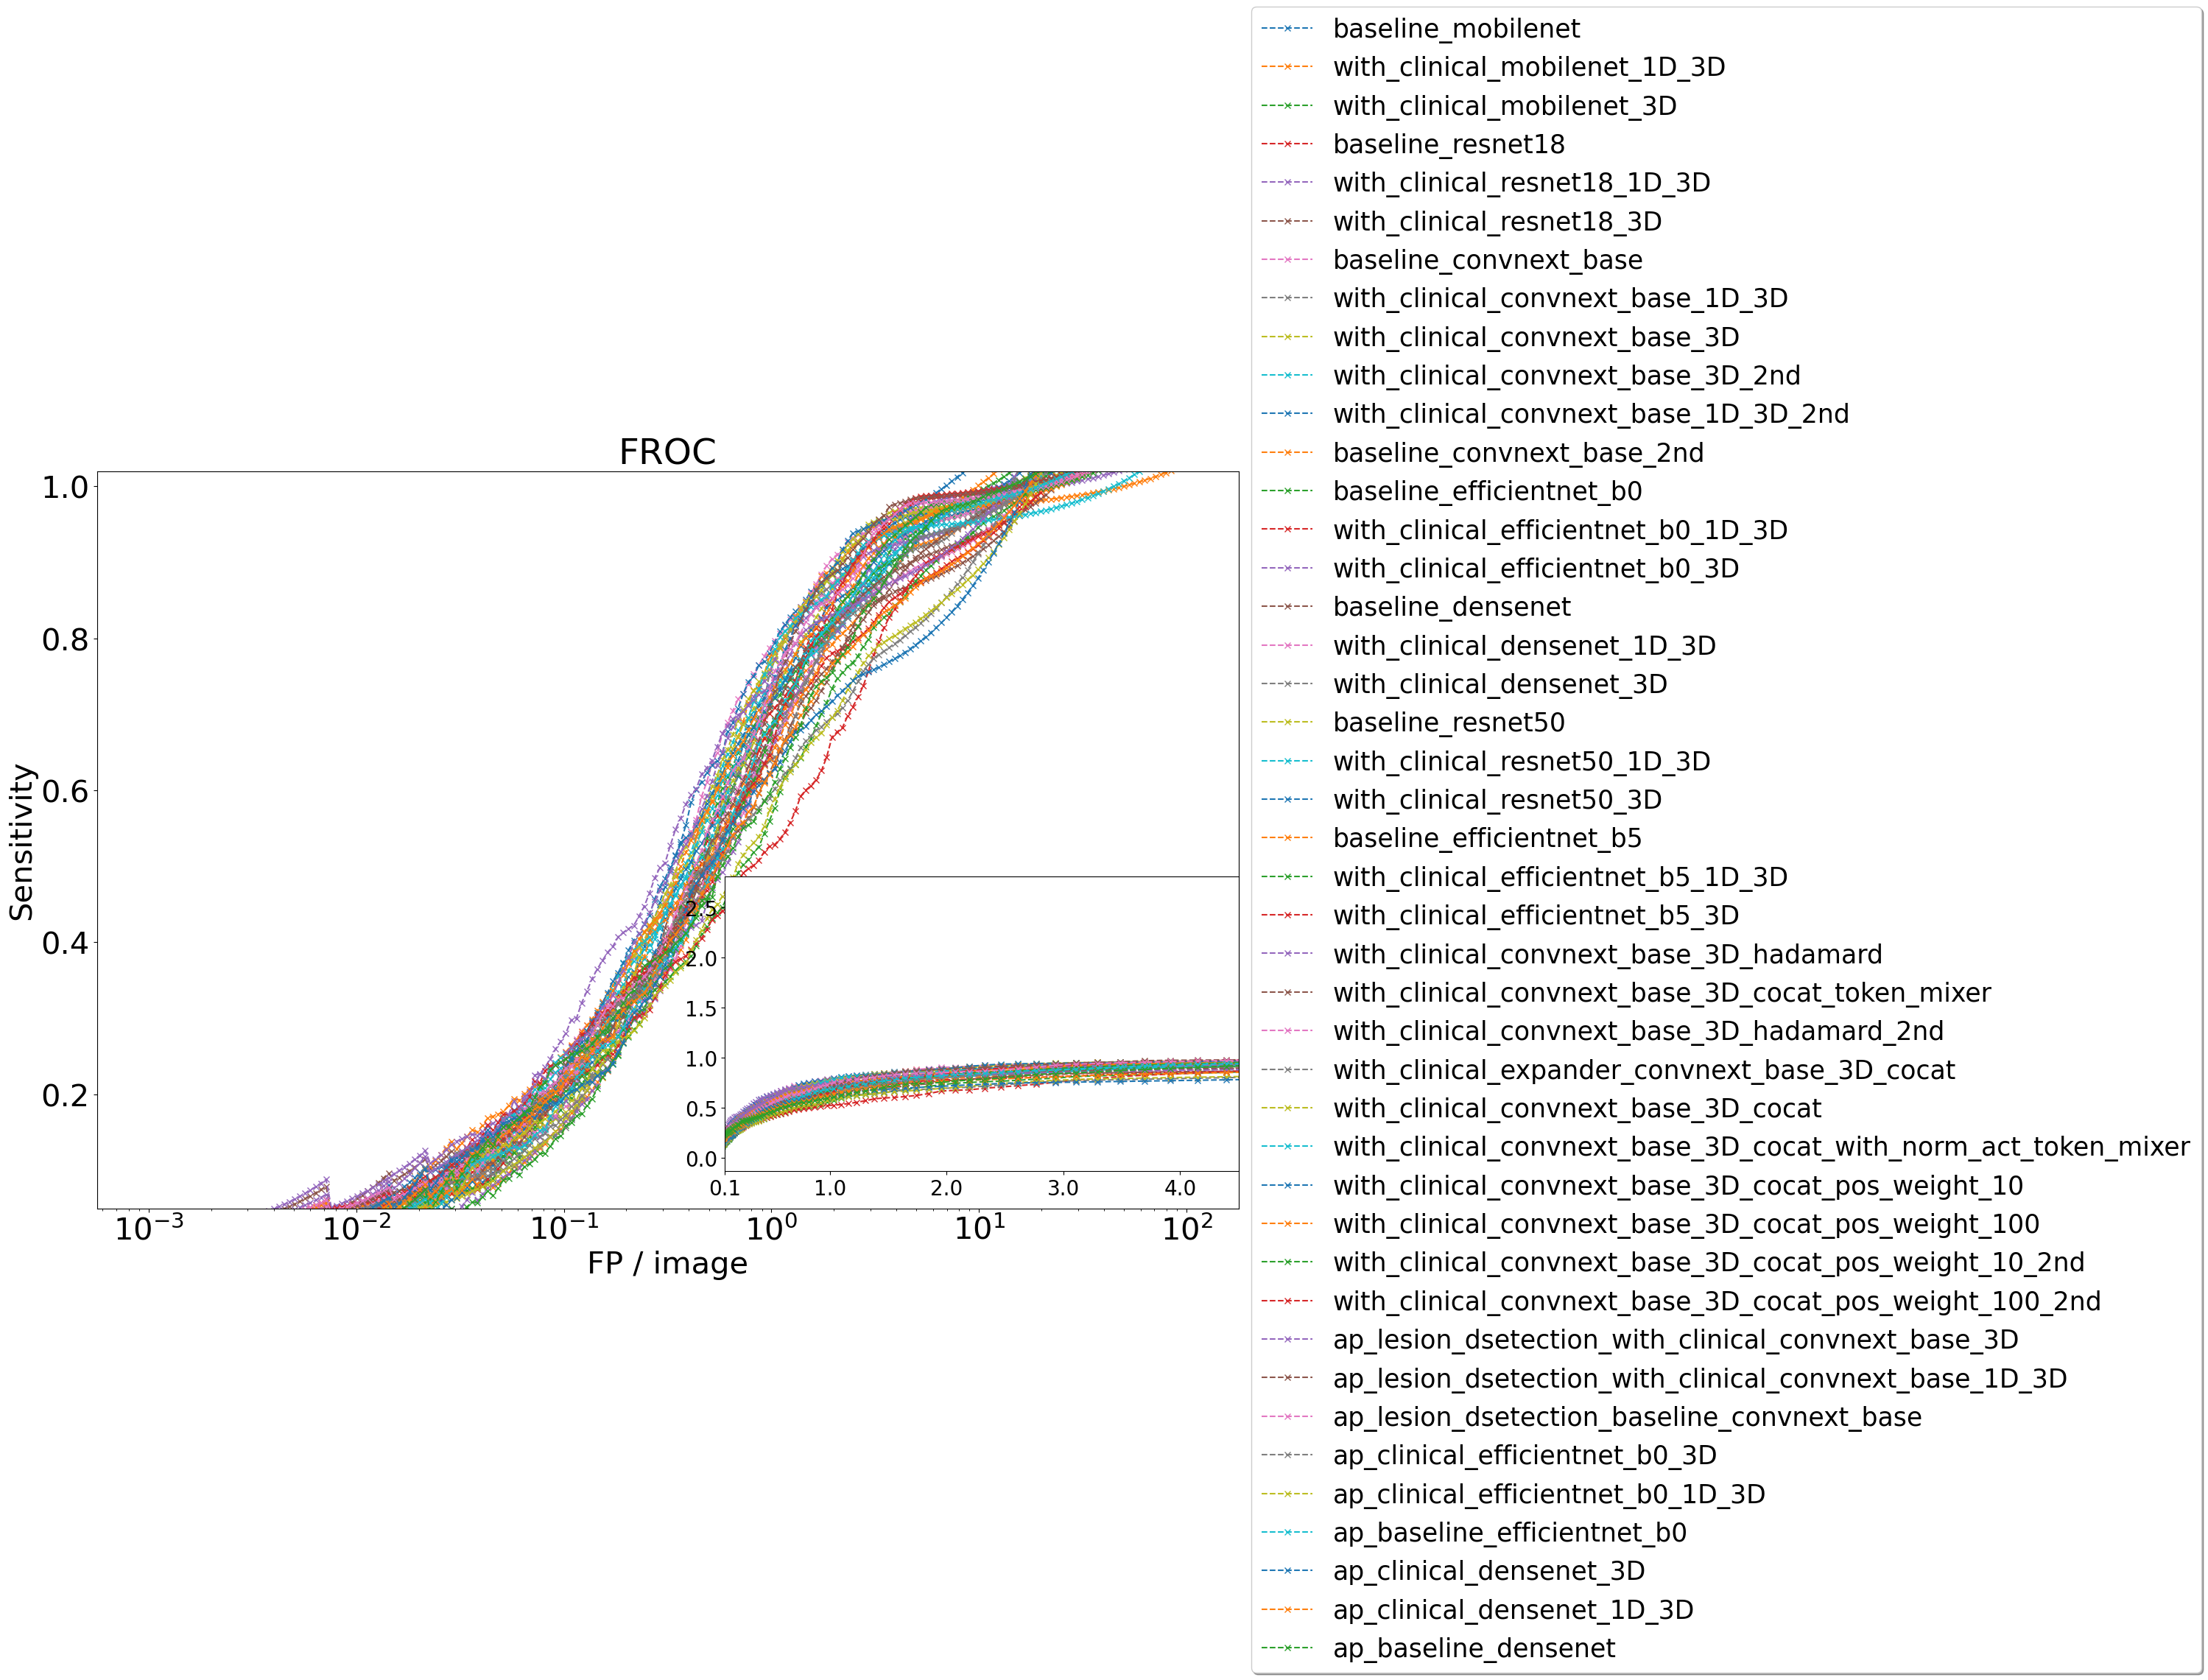

In [10]:
fig, ax = plt.subplots(figsize=[25, 13])

ins = ax.inset_axes([0.55, 0.05, 0.45, 0.4])
ins.set_xticks(
    [0.1, 1.0, 2.0, 3.0, 4.0],
    [
        0.1,
        1.0,
        2.0,
        3.0,
        4.0,
    ],
    fontsize=30,
)

ins.set_xlim([0.1, 4.5])

for idx, eval_instance in eval_df[eval_df["lesion"] == "all"].iterrows():
    froc_curve = json.loads(eval_instance["froc_curve"])
    x_axis = json.loads(eval_instance["x-axis"])
    name = eval_instance["model"]
    ax.semilogx(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )
    ins.plot(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(
    loc="center left",
    # bbox_to_anchor=(0.8, 0.6),
    bbox_to_anchor=(1, 0.5),

    fancybox=True,
    shadow=True,
    ncol=1,
    fontsize=25,
)

ax.set_title("FROC", fontdict={"fontsize": 35})
ax.set_ylabel("Sensitivity", fontdict={"fontsize": 30})
ax.set_xlabel("FP / image", fontdict={"fontsize": 30})

ax.tick_params(axis="both", which="major", labelsize=30)
ins.tick_params(axis="both", which="major", labelsize=20)

ax.set_ylim(bottom=0.05, top=1.02)
fig.tight_layout(pad=4.0)
fig.savefig(fname="models_froc.png", dpi=150)

In [11]:
def get_early_stop_strategy_from_name(name: str):
    return "Average Precision" if name.startswith("ap_") else "FROC"

def get_fusion_method_from_name(name: str):
    if "1D" in name and "3D" in name:
        return "1D+3D"
    elif "1D" in name:
        return "1D"
    elif "3D" in name:
        return "3D"
    else:
        return ""

eval_df['Early Stop'] = eval_df['model'].apply(get_early_stop_strategy_from_name)
eval_df['Fusion'] = eval_df['model'].apply(get_fusion_method_from_name)

In [12]:
eval_df = eval_df[[
    "model",
    "lesion",
    "Early Stop",
    "Fusion",
    "num_tps",
    "num_fps",
    "num_fns",
    "Sensitivity@ [avgFP=0.5]",
    "Sensitivity@ [avgFP=1]",
    "Sensitivity@ [avgFP=2]",
    "Sensitivity@ [avgFP=4]",
    "mFROC@[0.5,1,2,4]",
    " Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50      | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50      | area=   all | maxDets= 30 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
]]


In [13]:
eval_df = eval_df.rename(columns={"num_tps": "#TP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fps": "#FP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fns":"#FN @[ IoBB=0.50      | area=   all | maxDets= 30 ]"})

In [14]:
eval_df

,model,lesion,Early Stop,Fusion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,baseline_mobilenet,Pulmonary edema,FROC,,31,692,11,0.410714,0.755952,0.928571,...,0.032901,0.067286,0.071911,0.128601,0.075103,0.738095,0.154762,0.423810,0.530952,0.559524
0,baseline_mobilenet,Enlarged cardiac silhouette,FROC,,33,191,27,0.537500,0.786458,0.866667,...,0.178843,0.202561,0.205049,0.290857,0.237507,0.550000,0.356667,0.456667,0.475000,0.475000
0,baseline_mobilenet,Consolidation,FROC,,29,316,26,0.659394,0.825589,0.847847,...,0.044086,0.084830,0.092880,0.190301,0.071876,0.527273,0.114545,0.298182,0.383636,0.401818
0,baseline_mobilenet,Atelectasis,FROC,,29,147,30,0.599274,0.684181,0.750235,...,0.087479,0.115693,0.116986,0.212462,0.094733,0.491525,0.188136,0.325424,0.338983,0.338983
0,baseline_mobilenet,Pleural abnormality,FROC,,2,5,53,0.346524,0.553719,0.674568,...,0.012541,0.010891,0.010891,0.029703,0.004950,0.036364,0.018182,0.018182,0.018182,0.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ap_baseline_densenet,Enlarged cardiac silhouette,Average Precision,,37,235,23,0.533333,0.666667,0.802381,...,0.184116,0.209186,0.211352,0.290304,0.250265,0.616667,0.346667,0.485000,0.510000,0.523333
0,ap_baseline_densenet,Consolidation,Average Precision,,20,112,35,0.509091,0.692490,0.797861,...,0.030443,0.069397,0.069148,0.134479,0.061035,0.363636,0.114545,0.243636,0.243636,0.243636
0,ap_baseline_densenet,Atelectasis,Average Precision,,24,156,35,0.478814,0.532203,0.781983,...,0.064983,0.106856,0.108514,0.195777,0.095463,0.406780,0.142373,0.259322,0.281356,0.284746
0,ap_baseline_densenet,Pleural abnormality,Average Precision,,12,48,43,0.419318,0.579144,0.679870,...,0.011683,0.029120,0.029120,0.061155,0.020342,0.218182,0.061818,0.140000,0.140000,0.140000


In [15]:
eval_df.to_csv("eval.csv")

In [16]:
eval_df = eval_df[eval_df['lesion'] == 'all'] 
eval_df.to_csv("model_eval.csv")

In [17]:
eval_df

,model,lesion,Early Stop,Fusion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,baseline_mobilenet,all,FROC,,121,1362,150,0.517279,0.720170,0.808106,...,0.076838,0.101217,0.104680,0.179909,0.099356,0.457413,0.163524,0.300473,0.337960,0.355405
0,with_clinical_mobilenet_1D_3D,all,FROC,1D+3D,115,1080,156,0.490335,0.682397,0.795589,...,0.060228,0.081140,0.082583,0.151158,0.068201,0.436144,0.145889,0.283044,0.306894,0.316894
0,with_clinical_mobilenet_3D,all,FROC,3D,116,985,155,0.524934,0.687756,0.816052,...,0.061354,0.089564,0.091071,0.158283,0.080556,0.423176,0.157636,0.308287,0.331226,0.331559
0,baseline_resnet18,all,FROC,,135,1340,136,0.546300,0.703829,0.856160,...,0.060168,0.086925,0.089911,0.176481,0.072181,0.503293,0.157829,0.323343,0.362623,0.368813
0,with_clinical_resnet18_1D_3D,all,FROC,1D+3D,124,1241,147,0.461851,0.651903,0.820755,...,0.040523,0.063562,0.066380,0.135308,0.058869,0.462085,0.132074,0.285241,0.324863,0.337941
0,with_clinical_resnet18_3D,all,FROC,3D,113,537,158,0.497079,0.627148,0.772591,...,0.080158,0.109613,0.108386,0.184002,0.094183,0.419784,0.176490,0.294354,0.298393,0.300774
0,baseline_convnext_base,all,FROC,,98,397,173,0.620234,0.791219,0.875496,...,0.090337,0.121364,0.121420,0.178460,0.124453,0.367983,0.172008,0.272838,0.274266,0.274266
0,with_clinical_convnext_base_1D_3D,all,FROC,1D+3D,123,1718,148,0.518733,0.762702,0.872097,...,0.065628,0.087682,0.089749,0.168708,0.080250,0.464959,0.157609,0.289023,0.320483,0.341436
0,with_clinical_convnext_base_3D,all,FROC,3D,114,818,157,0.513407,0.713368,0.869317,...,0.056588,0.084695,0.084582,0.165577,0.064100,0.428905,0.143429,0.270089,0.277925,0.280306
0,with_clinical_convnext_base_3D_2nd,all,FROC,3D,106,476,165,0.583714,0.738236,0.824168,...,0.081074,0.114041,0.114013,0.176953,0.111365,0.398992,0.162078,0.294205,0.296443,0.296443


In [18]:
eval_df = eval_df[eval_df['lesion'] == 'all'].sort_values('mFROC@[0.5,1,2,4]',ascending=False)
eval_df.to_csv("model_eval_sort_froc.csv")

In [19]:
eval_df

,model,lesion,Early Stop,Fusion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,with_clinical_convnext_base_1D_3D_2nd,all,FROC,1D+3D,135,1237,136,0.627732,0.786144,0.885517,...,0.076096,0.108346,0.110862,0.191332,0.102276,0.508838,0.168042,0.326404,0.360927,0.369802
0,baseline_convnext_base_2nd,all,FROC,,147,1124,124,0.576793,0.779685,0.894793,...,0.071256,0.110517,0.112998,0.209050,0.100514,0.552337,0.153808,0.347896,0.377925,0.381336
0,with_clinical_convnext_base_3D_cocat,all,FROC,3D,103,1853,168,0.593729,0.772107,0.893322,...,0.031736,0.040903,0.044377,0.082544,0.041750,0.395504,0.101760,0.206019,0.254517,0.283803
0,baseline_convnext_base,all,FROC,,98,397,173,0.620234,0.791219,0.875496,...,0.090337,0.121364,0.121420,0.178460,0.124453,0.367983,0.172008,0.272838,0.274266,0.274266
0,baseline_resnet50,all,FROC,,116,1034,155,0.570749,0.763666,0.886112,...,0.064290,0.087048,0.088598,0.160038,0.079994,0.437746,0.144288,0.282978,0.305350,0.307731
0,with_clinical_convnext_base_3D_cocat_pos_weigh...,all,FROC,3D,109,1303,162,0.589568,0.739746,0.894945,...,0.054938,0.070509,0.075128,0.142918,0.069068,0.414141,0.125491,0.240276,0.290947,0.306852
0,with_clinical_convnext_base_3D_hadamard,all,FROC,3D,120,611,151,0.634834,0.761258,0.865140,...,0.085637,0.128907,0.130687,0.218152,0.122563,0.455915,0.166618,0.316561,0.333804,0.334756
0,ap_lesion_dsetection_baseline_convnext_base,all,Average Precision,,135,1138,136,0.553857,0.742289,0.854874,...,0.074130,0.107093,0.109555,0.184228,0.103136,0.507876,0.175420,0.337769,0.366661,0.371692
0,with_clinical_convnext_base_3D_cocat_with_norm...,all,FROC,3D,115,1245,156,0.527307,0.775330,0.871206,...,0.044234,0.064062,0.066144,0.126062,0.061525,0.440744,0.122753,0.248672,0.284556,0.298317
0,with_clinical_convnext_base_3D_cocat_pos_weigh...,all,FROC,3D,108,1753,163,0.577111,0.727073,0.850338,...,0.036385,0.047802,0.050319,0.107446,0.041224,0.415197,0.103471,0.220150,0.261869,0.288059


In [20]:
eval_df  = eval_df.sort_values(' Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ]',ascending=False)
eval_df

,model,lesion,Early Stop,Fusion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,with_clinical_convnext_base_3D_hadamard,all,FROC,3D,120,611,151,0.634834,0.761258,0.865140,...,0.085637,0.128907,0.130687,0.218152,0.122563,0.455915,0.166618,0.316561,0.333804,0.334756
0,baseline_convnext_base_2nd,all,FROC,,147,1124,124,0.576793,0.779685,0.894793,...,0.071256,0.110517,0.112998,0.209050,0.100514,0.552337,0.153808,0.347896,0.377925,0.381336
0,with_clinical_convnext_base_1D_3D_2nd,all,FROC,1D+3D,135,1237,136,0.627732,0.786144,0.885517,...,0.076096,0.108346,0.110862,0.191332,0.102276,0.508838,0.168042,0.326404,0.360927,0.369802
0,with_clinical_resnet18_3D,all,FROC,3D,113,537,158,0.497079,0.627148,0.772591,...,0.080158,0.109613,0.108386,0.184002,0.094183,0.419784,0.176490,0.294354,0.298393,0.300774
0,ap_lesion_dsetection_baseline_convnext_base,all,Average Precision,,135,1138,136,0.553857,0.742289,0.854874,...,0.074130,0.107093,0.109555,0.184228,0.103136,0.507876,0.175420,0.337769,0.366661,0.371692
0,baseline_mobilenet,all,FROC,,121,1362,150,0.517279,0.720170,0.808106,...,0.076838,0.101217,0.104680,0.179909,0.099356,0.457413,0.163524,0.300473,0.337960,0.355405
0,baseline_convnext_base,all,FROC,,98,397,173,0.620234,0.791219,0.875496,...,0.090337,0.121364,0.121420,0.178460,0.124453,0.367983,0.172008,0.272838,0.274266,0.274266
0,with_clinical_convnext_base_3D_2nd,all,FROC,3D,106,476,165,0.583714,0.738236,0.824168,...,0.081074,0.114041,0.114013,0.176953,0.111365,0.398992,0.162078,0.294205,0.296443,0.296443
0,baseline_resnet18,all,FROC,,135,1340,136,0.546300,0.703829,0.856160,...,0.060168,0.086925,0.089911,0.176481,0.072181,0.503293,0.157829,0.323343,0.362623,0.368813
0,with_clinical_convnext_base_3D_cocat_pos_weigh...,all,FROC,3D,119,987,152,0.471360,0.653365,0.844747,...,0.068115,0.096045,0.097279,0.173668,0.086558,0.447031,0.142270,0.284497,0.309653,0.314606


In [21]:
eval_df.to_csv("model_eval_sort_ap.csv")
